![Alt text](new.png)

# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import product  # Import product for grid search
import warnings
from matplotlib.backends.backend_pdf import PdfPages
warnings.simplefilter('ignore')

# Method 2: group proposed equation based on student equation

In [60]:
# Define the Polynomial-Log Hybrid Model
def strain_rate_dependent_stress(sr, C1, C2, C3, C4):
    return C1 * np.log(sr) + C2 * sr**C3 + C4 * (np.log(sr))**2

def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    # Load the temperature-specific file
    data = pd.read_csv(f"../{temperature_file}.csv")
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1

    # List to store the results
    results = []

    # PDF file to save plots
    pdf_filename = f"Plots_{temperature_file}.pdf"
    
    with PdfPages(pdf_filename) as pdf:
        # Loop through all rows in the dataset for strain-rate dependency fitting
        for i in range(len(data)):
            # Extract stress data for other strain rates
            stress_values = data.iloc[i][strain_rate_columns]
            
            # Initial guess and bounds for C1, C2, C3, and C4
            initial_guess_sr = [0.1, 0.1, 0.1, 0.1] 
            
            # Perform the curve fitting
            try:
                params_sr, _ = curve_fit(
                    lambda sr, C1, C2, C3, C4: strain_rate_dependent_stress(sr, C1, C2, C3, C4),
                    strain_rates, stress_values, p0=initial_guess_sr, maxfev=10000000, method='dogbox'
                )
            except RuntimeError:
                print(f"Could not fit strain-rate dependency for row {i}")
                continue
            
            # Calculate residuals and R-squared
            stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr)
            residuals = stress_values - stress_fit
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Store results for exporting
            results.append({
                "PEEQ": data['strain'].iloc[i],
                "C1": params_sr[0],
                "C2": params_sr[1],
                "C3": params_sr[2],
                "C4": params_sr[3],
                "R_squared": r_squared
            })
            
            # Plot only for specified rows with scaled C1, C2, C3, and C4 in legend
            plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
            plt_stress_fit = strain_rate_dependent_stress(plt_strain_rates, *params_sr)
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(plt_strain_rates, plt_stress_fit, '-', label='Fit')  # Fit plot
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"PEEQ={data['strain'].iloc[i]} (R² = {r_squared:.3f})", fontweight='bold')
            #plt.legend([f'Data', f'Fit: C1={params_sr[0]:.2f}, C2={params_sr[1]:.2f}, C3={params_sr[2]:.2f}, C4={params_sr[3]:.2f}'], loc="lower right")
            plt.legend(['Data', 'Fit'], loc="upper right")
            pdf.savefig()  # Save the current figure to the PDF
            plt.close()

    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}_new.csv", index=False)


## Finding parameters

In [62]:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

temperature_file = 'Tmp673.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

# Check R1 score
## Check to see if any R1 < 0.95

In [52]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.97
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_low_r_squared = df[df['R_squared'] < threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_low_r_squared > 0:
            print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
            print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
            #print(df[df['R_squared'] < threshold]['PEEQ'])
        else:
            print(f"All R_squared values are >= {threshold}.")

        r = min(df['R_squared'])
        r_a = sum(df['R_squared'])/total_rows
        print(f'Min = {r}. Average = {r_a}')

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
Number of rows with R_squared < 0.97: 2
Percentage of rows with R_squared < 0.97: 0.51%
Min = 0.9676570825082258. Average = 0.9860474365211933

Temperature File: Parameters_Tmp373.15_RD.csv
All R_squared values are >= 0.97.
Min = 1.0. Average = 1.0

Temperature File: Parameters_Tmp473.15_RD.csv
All R_squared values are >= 0.97.
Min = 1.0. Average = 1.0

Temperature File: Parameters_Tmp573.15_RD.csv
All R_squared values are >= 0.97.
Min = 1.0. Average = 1.0

Temperature File: Parameters_Tmp673.15_RD.csv
All R_squared values are >= 0.97.
Min = 0.97471620481191. Average = 0.9999359903919288


# Calibrate C1, C2 based on strain dependent

## Study relationship between C1, C2
C1, C2 follows the same trend for a condition and is dependent on strain rate => Use the same strain dependent function

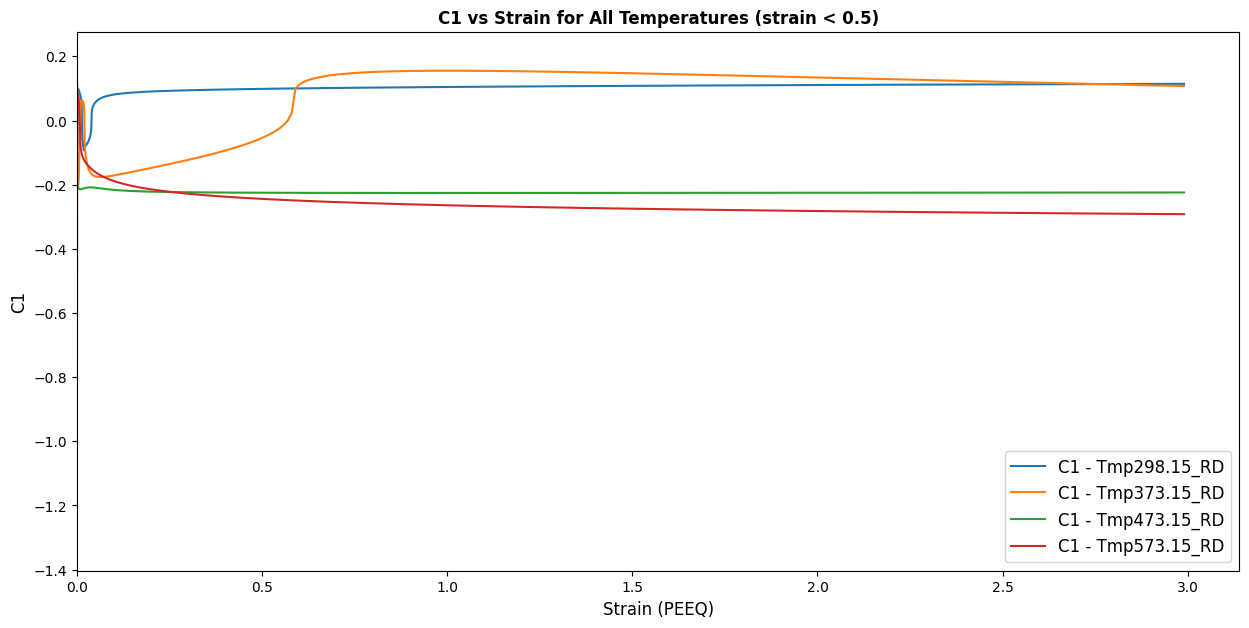

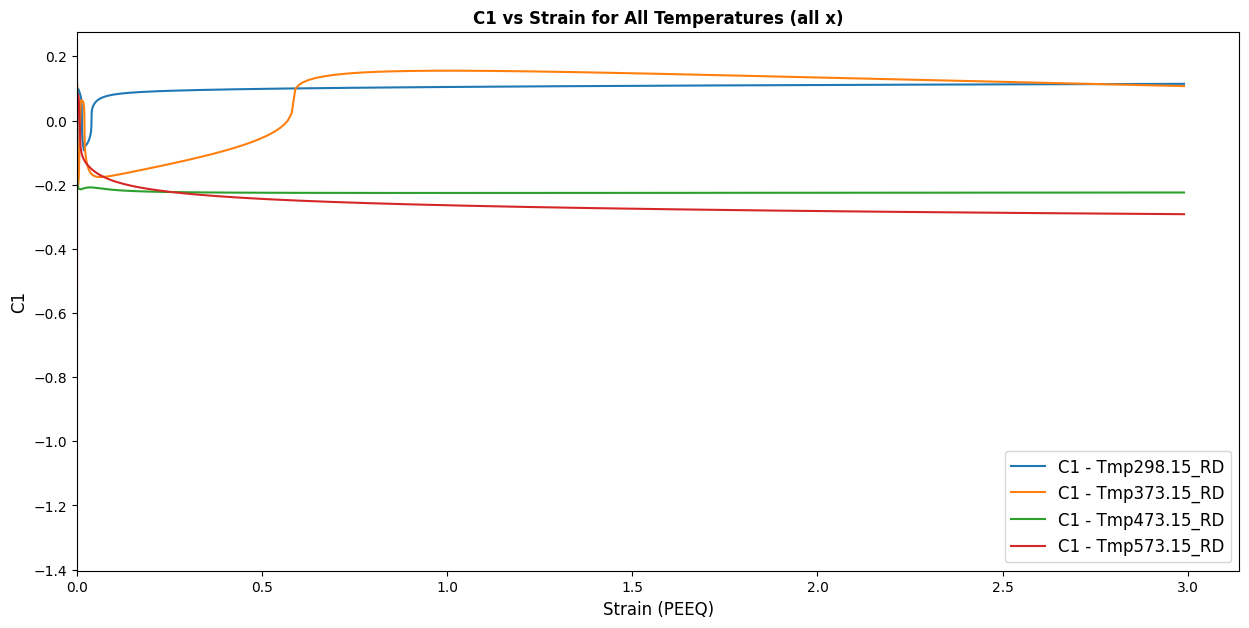

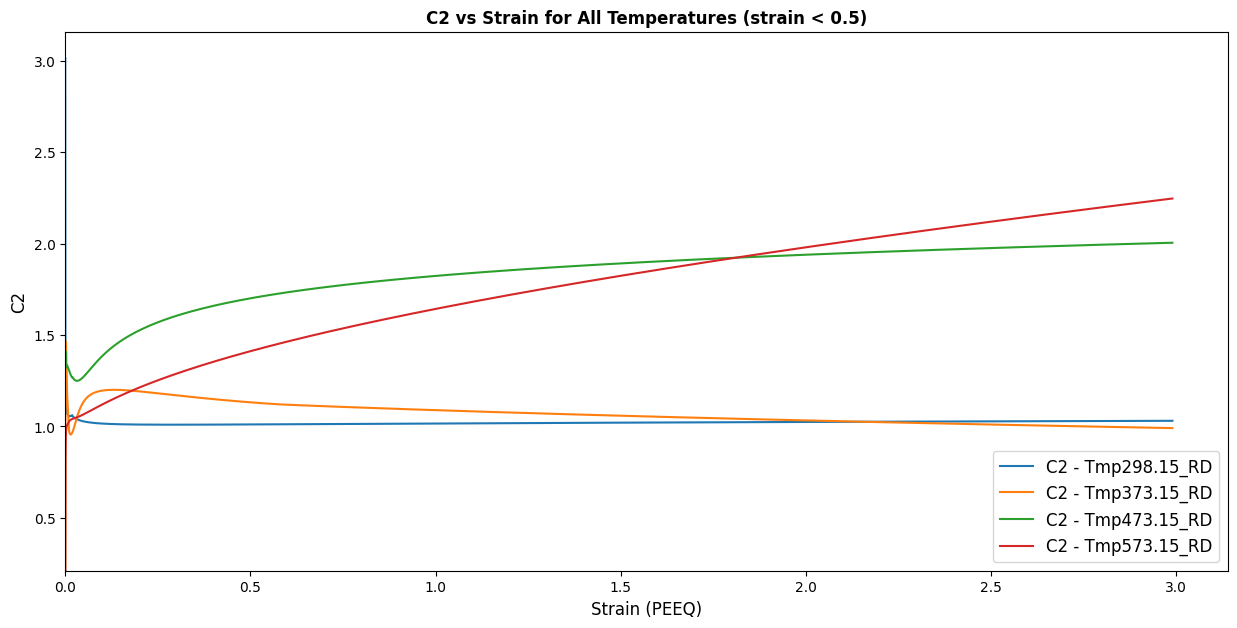

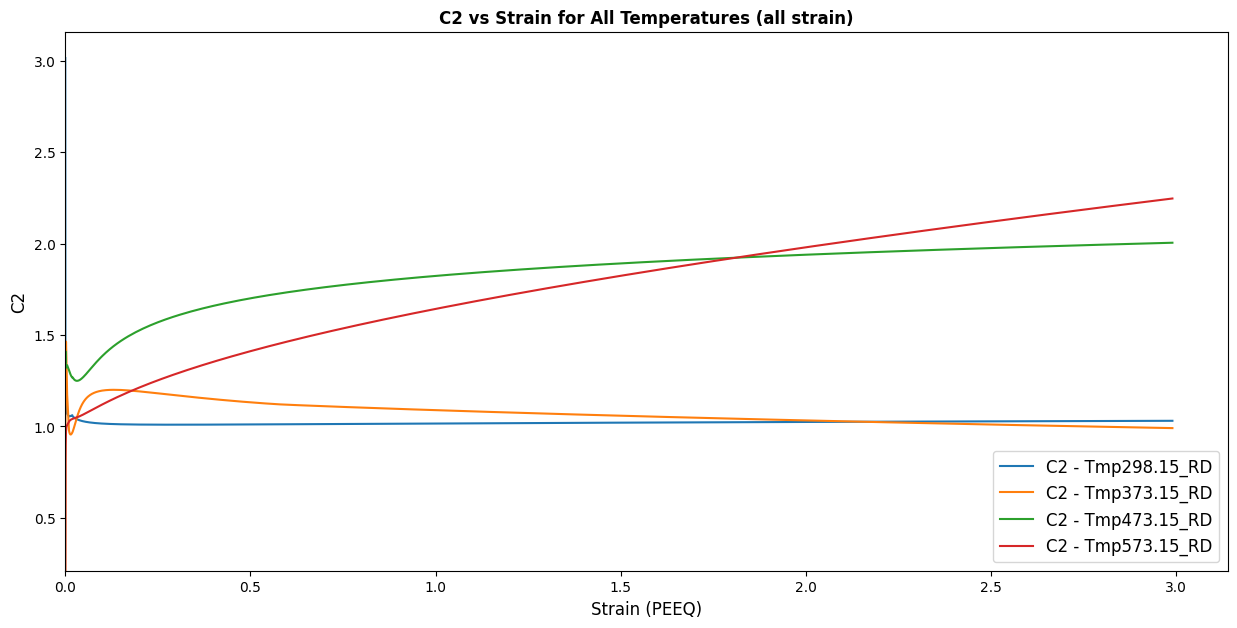

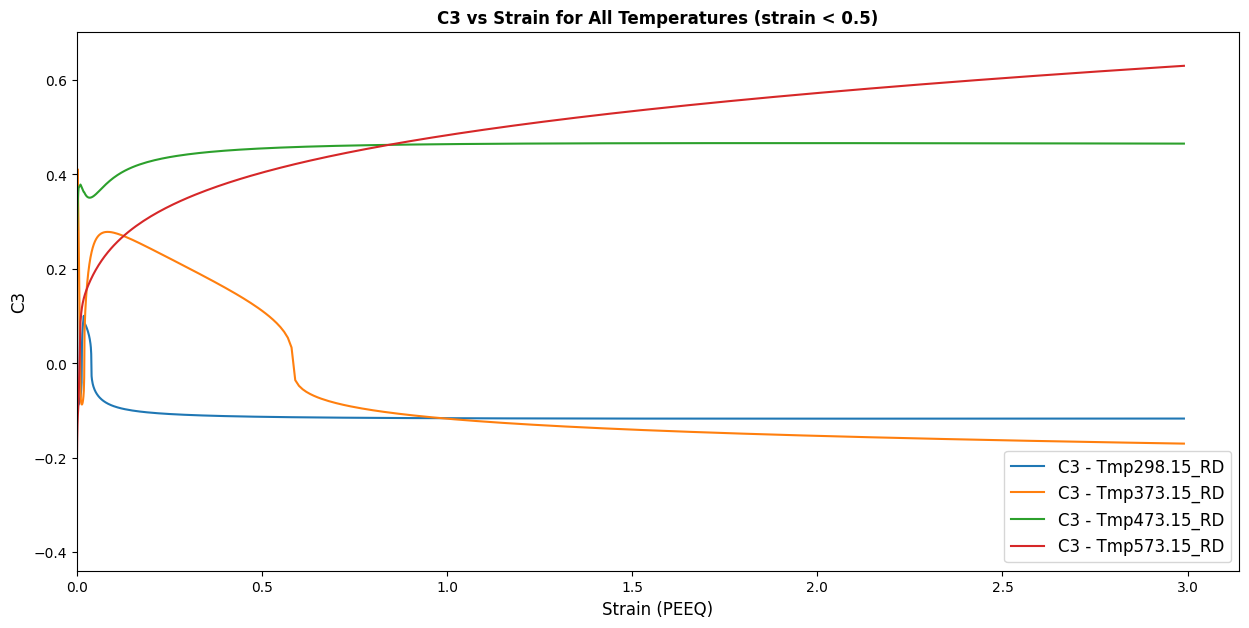

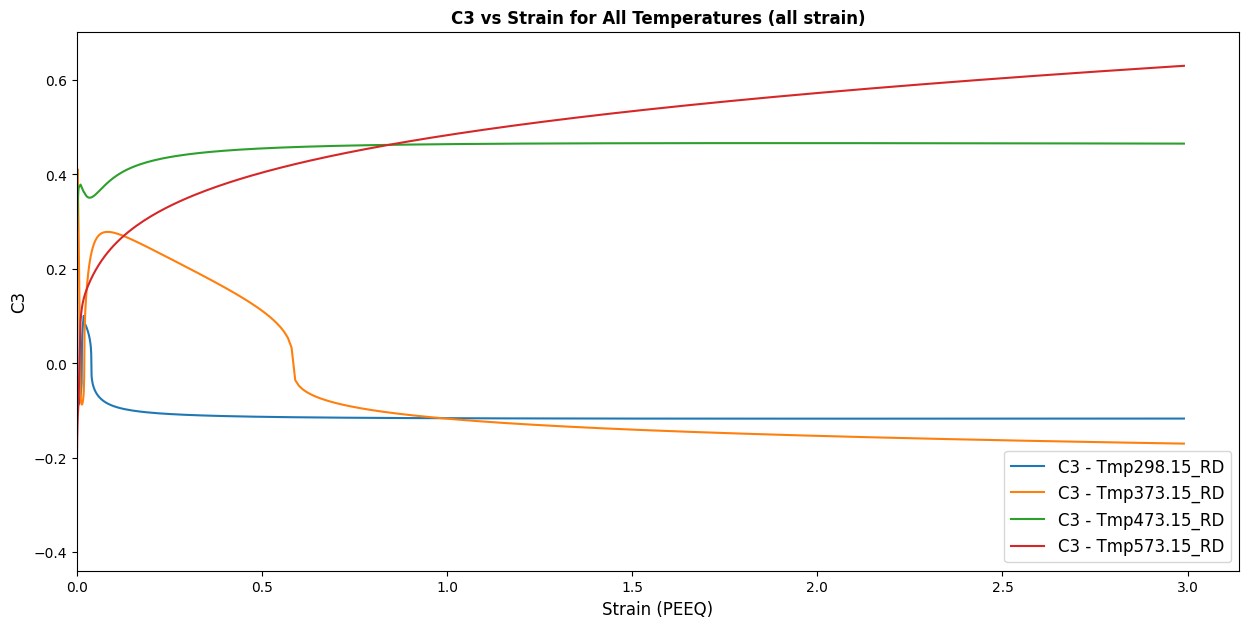

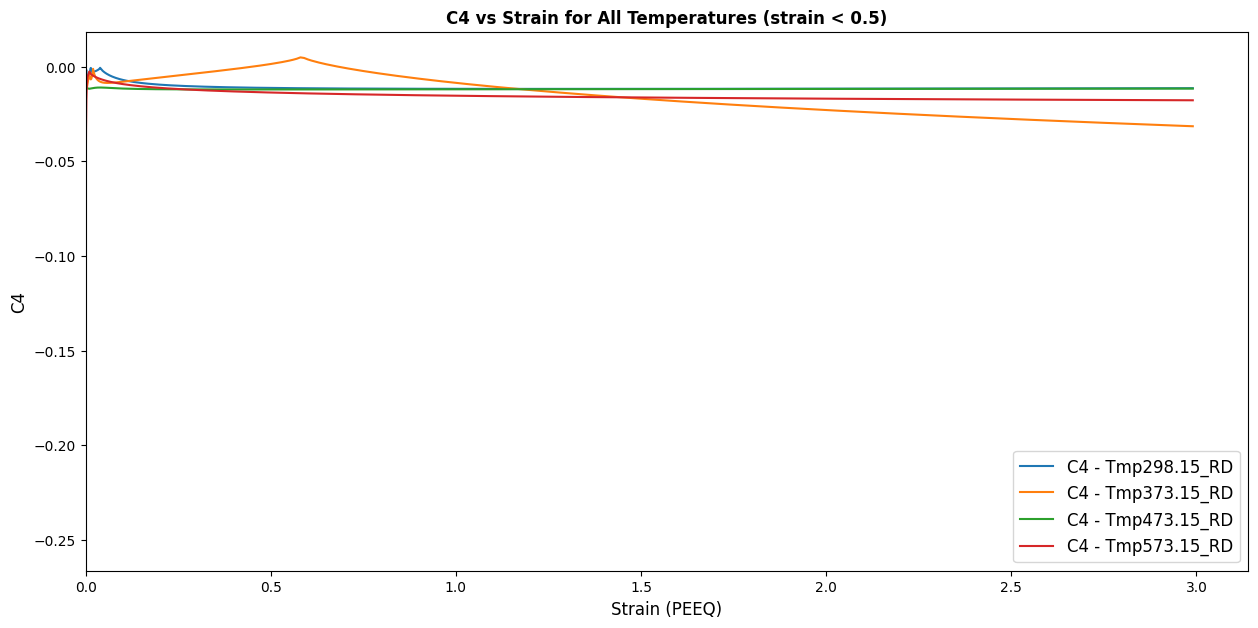

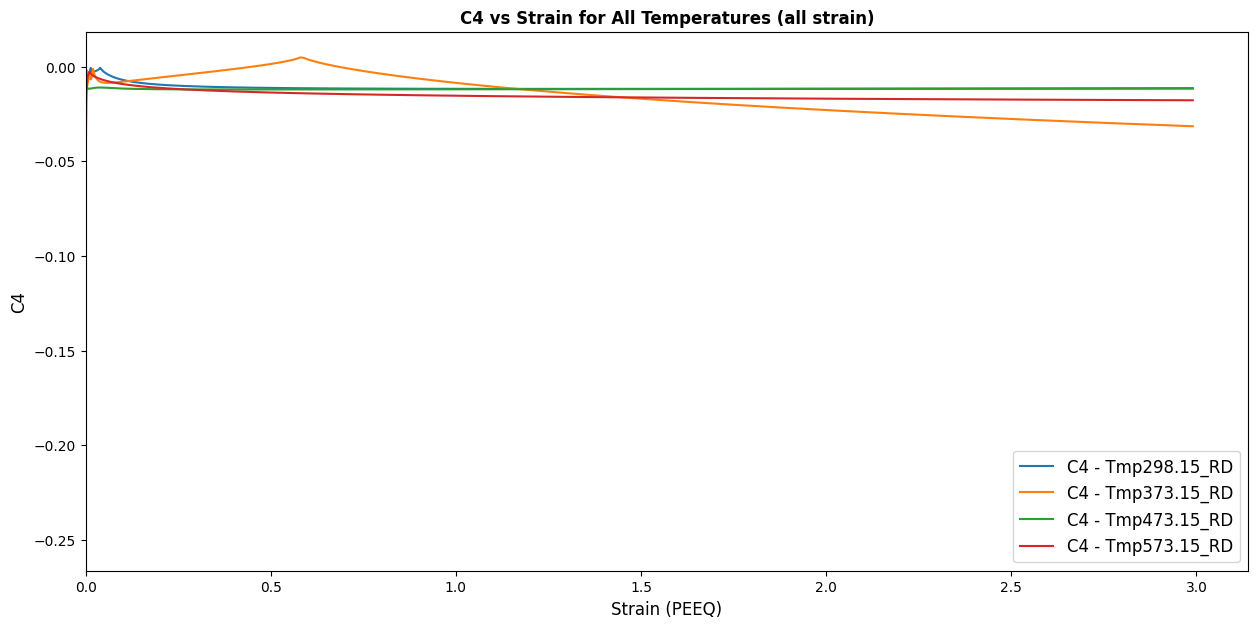

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD']

# Function to plot parameters based on condition
def plot_parameters(df, x_col, y_col, filter_condition, title, xlabel, ylabel):
    plt.figure(figsize=(15, 7))
    for temp_file in temperature_files:
        df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
        if filter_condition == "x < 0.5":
            filtered_df = df[df[x_col] < 0.5]
        else:
            filtered_df = df
        plt.plot(filtered_df[x_col], filtered_df[y_col], label=f'{y_col} - {temp_file}')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{title} ({filter_condition})', fontweight='bold', fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.xlim(left=0)
    plt.ylim(bottom=min(df[y_col]))
    plt.show()

# Plot C1
plot_parameters(df=None, x_col='PEEQ', y_col='C1', filter_condition="strain < 0.5",
                title='C1 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C1')
plot_parameters(df=None, x_col='PEEQ', y_col='C1', filter_condition="all x",
                title='C1 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C1')

# Plot C2
plot_parameters(df=None, x_col='PEEQ', y_col='C2', filter_condition="strain < 0.5",
                title='C2 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C2')
plot_parameters(df=None, x_col='PEEQ', y_col='C2', filter_condition="all strain",
                title='C2 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C2')

# Plot C3
plot_parameters(df=None, x_col='PEEQ', y_col='C3', filter_condition="strain < 0.5",
                title='C3 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C3')
plot_parameters(df=None, x_col='PEEQ', y_col='C3', filter_condition="all strain",
                title='C3 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C3')

# Plot C4
plot_parameters(df=None, x_col='PEEQ', y_col='C4', filter_condition="strain < 0.5",
                title='C4 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C4')
plot_parameters(df=None, x_col='PEEQ', y_col='C4', filter_condition="all strain",
                title='C4 vs Strain for All Temperatures', xlabel='Strain (PEEQ)', ylabel='C4')


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD']
# Parameters to plot
parameters = ['C1', 'C2', 'C3', 'C4']

# Load and combine data from all temperature files
all_data = []
for temp_file in temperature_files:
    df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
    df['Temperature'] = temp_file  # Add temperature file info
    all_data.append(df)
combined_data = pd.concat(all_data)

# Generate PDFs for each parameter
for param in parameters:
    output_pdf = f"incremental_plots_{param}.pdf"
    with PdfPages(output_pdf) as pdf:
        # Get unique PEEQ values and sort them
        unique_peeq = sorted(combined_data['PEEQ'].unique())
        for i in range(1, len(unique_peeq) + 1):
            max_peeq = unique_peeq[i - 1]
            plt.figure(figsize=(15, 7))
            for temp_file in temperature_files:
                # Filter data for current temperature and up to the current PEEQ limit
                temp_data = combined_data[(combined_data['Temperature'] == temp_file) & (combined_data['PEEQ'] <= max_peeq)]
                plt.plot(temp_data['PEEQ'], temp_data[param], label=f'{param} - {temp_file}')
            plt.xlabel('Strain (PEEQ)', fontsize=12)
            plt.ylabel(param, fontsize=12)
            plt.title(f'{param} vs Strain (PEEQ ≤ {max_peeq:.3f})', fontweight='bold', fontsize=12)
            plt.legend(loc='lower right', fontsize=12)
            plt.xlim(left=0)
            pdf.savefig()
            plt.close()
    print(f"Incremental plots for {param} saved to {output_pdf}")


Incremental plots for C1 saved to incremental_plots_C1.pdf
Incremental plots for C2 saved to incremental_plots_C2.pdf
Incremental plots for C3 saved to incremental_plots_C3.pdf
Incremental plots for C4 saved to incremental_plots_C4.pdf


## Calibrate strain dependent function for C1 and C2

In [21]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}_new.csv")  # Replace with your actual file path
    #data = data[data['PEEQ'] > 0.0009]
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values
    C3_values = data['C3']  # C1 values
    C4_values = data['C4']  # C2 values

    # Define the stretched exponential model
    def C1_func(x, a1, b1, c1, d1, e1, a2, b2, c2, a3, b3, c3,d3, e3,f3,g3, threshold1=0.002, threshold2=0.04):
        # Low strain: Oscillatory component
        small_strain = a1 * np.exp(b1 * x) + c1 + d1*x**2 + e1*x 
        
        # Middle strain: Oscillatory component for waves
        middle_strain = a3 * np.sin(b3 * x + c3) * np.exp(-d3 * x) + e3 * x**2 + f3 * x + g3 
        
        # High strain: Stable behavior
        high_strain = a2 * np.exp(b2 * x) + c2
        
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )

    def C2_func(x, a, b, c, d, e, f, g):
        epsilon = 1e-6
        x_shifted = x + epsilon
        return (
            a * np.log(x_shifted) + 
            b * x_shifted**c + 
            d * np.exp(-e * x_shifted) + 
            f * np.exp(-((x - g)**2) / (2 * e**2))
        )


    def C3_func(x, a1, b1, c1, d1, a2, b2, c2, d2, a3,b3,c3, threshold1=0.002, threshold2=0.02):
        small_strain = a1*x**3 + b1*x**2 + c1*x + d1
        middle_strain = a2*x**3 + b2*x**2 + c2*x + d2
        high_strain = a3*x**2 + b3*x + c3
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )


    def C4_func(x, a1, b1, c1, d1, a2, b2, c2, a3, b3, c3,d3, e3,f3,g3, threshold1=0.002, threshold2=0.04):
        # Low strain: Oscillatory component
        small_strain = a1 * np.exp(b1 * x) * np.cos(c1 * x) + d1
        
        # Middle strain: Oscillatory component for waves
        middle_strain = a3 * np.sin(b3 * x + c3) * np.exp(-d3 * x) + e3 * x**2 + f3 * x + g3 
        
        # High strain: Stable behavior
        high_strain = a2 * np.exp(b2 * x) + c2
        
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )

    initial_guess_C1 = [0.1, -100, 100, 0.1, 1, 0.01, -0.5, -0.2, 0.02, 10, 0, 10, 0.01, -0.1, 0, 0.0015, 0.038]
    initial_guess_C2 = [1, 10, 0.5, 1, 0.1, 1, 0.01]
    initial_guess_C3 = [1,1,1,1,1,1,1,1,1,1,1]
    initial_guess_C4 = [-0.1, -1000, 1000, 0, -0.01, -50, 0.01, 0.1, 1.0, 0.0, 0.1, 0.0, 1.0, 0.0]
    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(C1_func, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)
    popt_C2, _ = curve_fit(C2_func, strain, C2_values, p0=initial_guess_C2, maxfev=10000000)
    popt_C3, _ = curve_fit(C3_func, strain, C3_values, p0=initial_guess_C3,maxfev=10000000)
    popt_C4, _ = curve_fit(C4_func, strain, C4_values, p0=initial_guess_C4, maxfev=10000000)


    # Generate fitted values using the stretched exponential model
    C1_fit = C1_func(strain, *popt_C1)
    C2_fit = C2_func(strain, *popt_C2)
    C3_fit = C3_func(strain, *popt_C3)
    C4_fit = C4_func(strain, *popt_C4)

    #if temp_file == 'Tmp673.15_RD':
        #C2_fit = pd.read_csv('Fitted_Parameters_Tmp673.15_RD_backup.csv')['C2']
        
    fitted_df = pd.DataFrame({
        'strain': strain,
        'C1': C1_fit,
        'C2': C2_fit,
        'C3': C3_fit,
        'C4': C4_fit
    })
    fitted_df.to_csv(f"Fitted_Parameters_{temp_file}.csv", index=False)

    # Calculate R^2 scores
    C_values = {'C1': C1_values, 'C2': C2_values, 'C3': C3_values, 'C4': C4_values}
    C_fits = {'C1': C1_fit, 'C2': C2_fit, 'C3': C3_fit, 'C4': C4_fit}
    r2_scores = {}

    for key in C_values:
        residuals = C_values[key] - C_fits[key]
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((C_values[key] - np.mean(C_fits[key]))**2)
        r2_scores[key] = 1 - (ss_res / ss_tot)

    
    # Plot C1 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain, C1_fit, '-', label='C1 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain {temp_file} (R^2: {r2_scores['C1']:.3f})")
    plt.show()

    # Plot C2 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain[1:], C2_values[1:], 'o', label='C2 Data')
    plt.plot(strain[1:], C2_fit[1:], '-', label='C2 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain {temp_file} (R^2: {r2_scores['C2']:.3f})")
    plt.show()

    # Plot C3 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C3_values, 'o', label='C3 Data')
    plt.plot(strain, C3_fit, '-', label='C3 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C3')
    plt.legend()
    plt.title(f"C3 vs Strain {temp_file} (R^2: {r2_scores['C3']:.3f})")
    plt.show()
    
     # Plot C4 vs Strain
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C4_values, 'o', label='C4 Data')
    plt.plot(strain, C4_fit, '-', label='C4 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C4')
    plt.legend()
    plt.title(f"C4 vs Strain Fit {temp_file} (R^2: {r2_scores['C4']:.3f})")
    plt.show()

    # Print the fitted parameters for reference
    print("Parameters for C1:", popt_C1)
    print("Parameters for C2:", popt_C2)
    print("Parameters for C3:", popt_C3)
    print("Parameters for C4:", popt_C4)


In [22]:
data = pd.read_csv('Parameters_Tmp673.15_RD_new.csv')
df.iloc[:, [0, 3]].to_csv('test.csv')

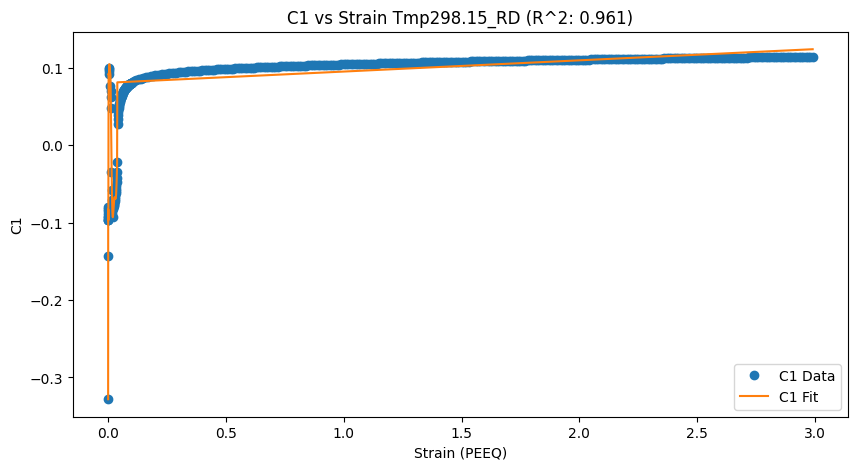

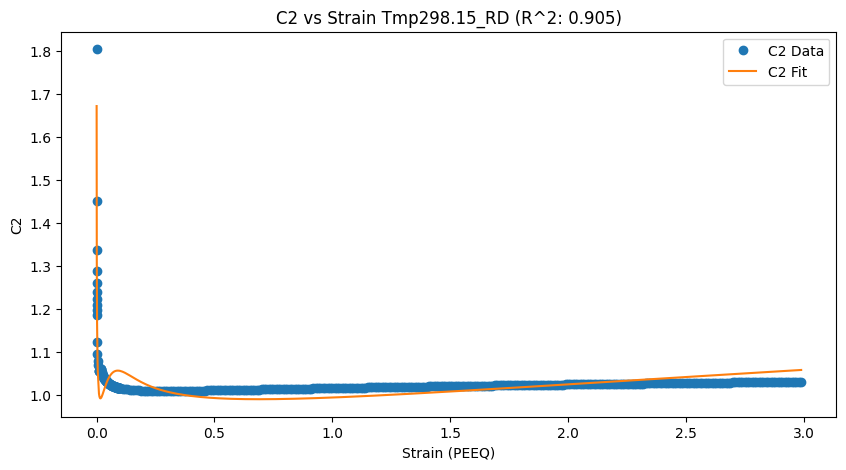

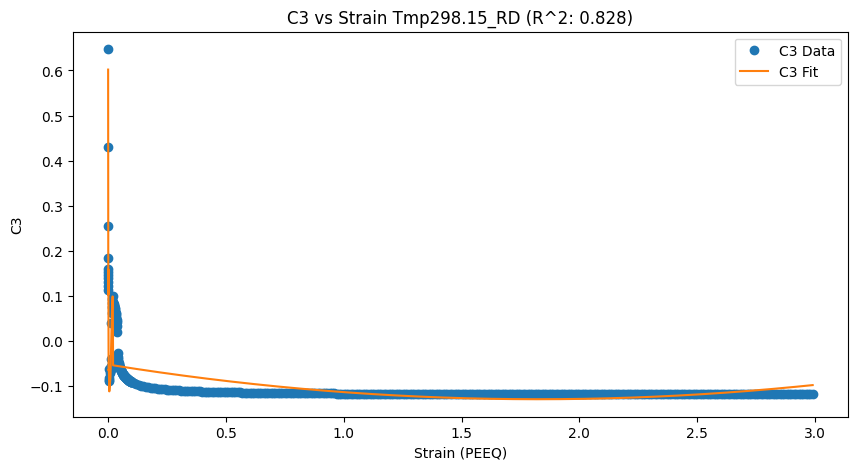

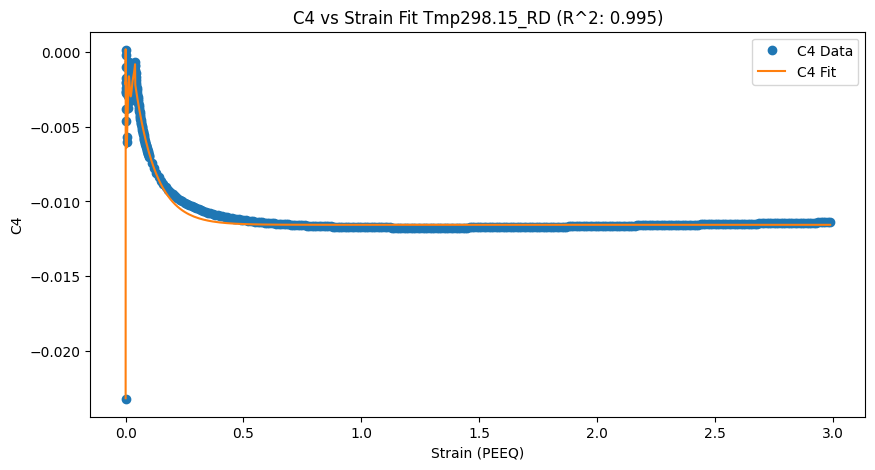

Parameters for C1: [-3.29595879e-01 -9.51545191e+03  1.39302977e-03  1.94297365e+05
 -2.75852797e+02  3.35481033e+02  4.32267577e-05 -3.35400225e+02
 -1.08975513e-01  3.58695258e+02 -5.14294391e+00  6.80068130e+01
  4.65431677e+02 -2.42242799e+01  2.30359228e-01  1.50000000e-03
  3.80000000e-02]
Parameters for C2: [-2.24959256e-01  1.05400691e+00  2.26710165e-01 -6.78415751e-02
  1.26540018e-01 -2.08661973e+02 -4.43844361e-01]
Parameters for C3: [-6.08701313e+08  1.93561507e+06 -1.76986929e+03  6.01926546e-01
 -2.15977919e+05  8.30650607e+03 -8.04426188e+01  1.10339544e-01
  2.30710953e-02 -8.42212415e-02 -5.17335012e-02]
Parameters for C4: [-2.11805508e-02 -9.09782930e+03 -1.13244066e+04 -1.99799077e-03
  1.49475241e-02 -1.13841700e+01 -1.15621063e-02 -8.31926006e-03
 -3.73047771e+02  3.93150795e+00  1.35509700e+02  2.72210037e+00
 -6.84828258e-02 -2.38629028e-03]


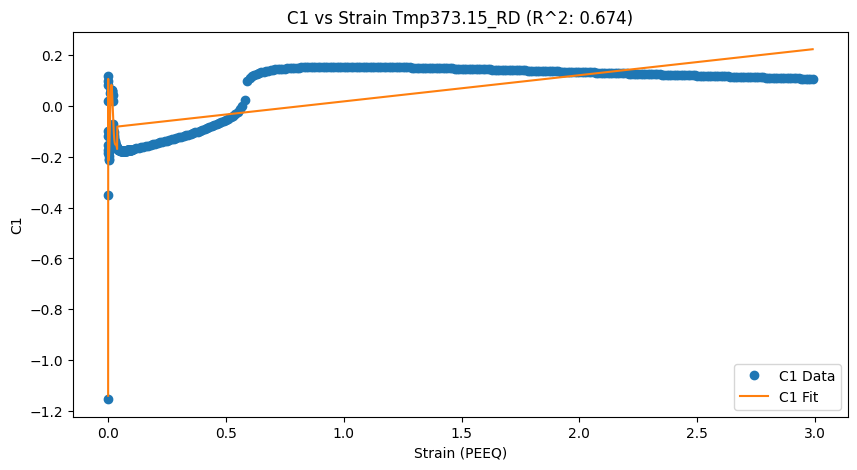

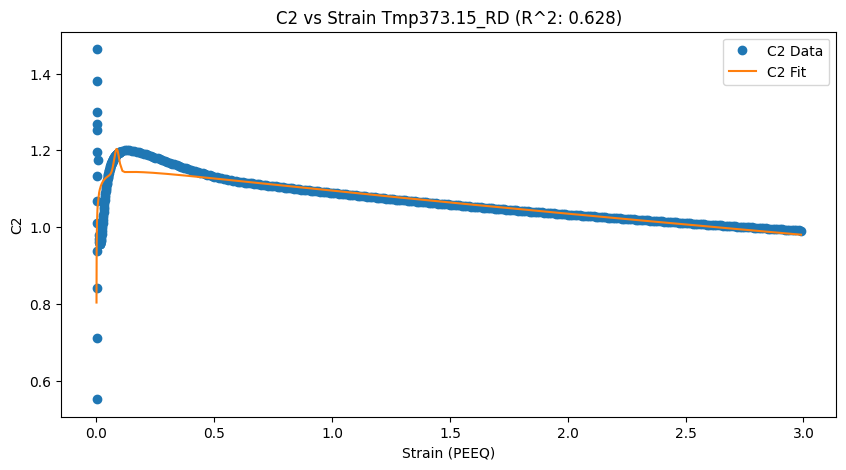

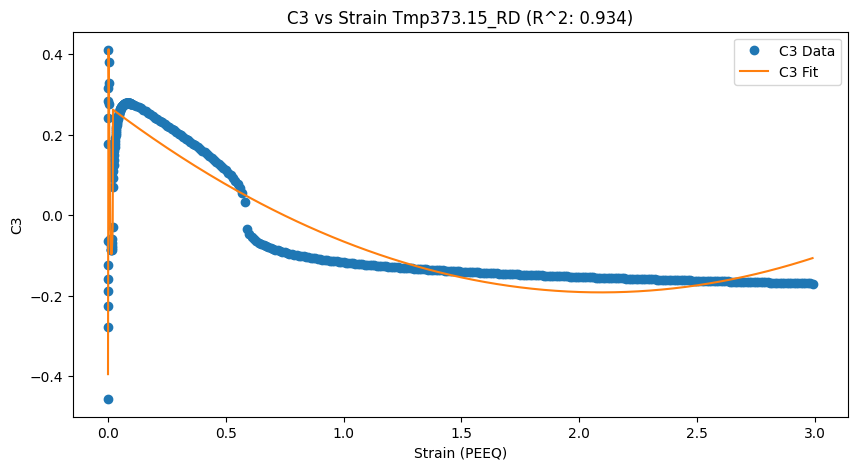

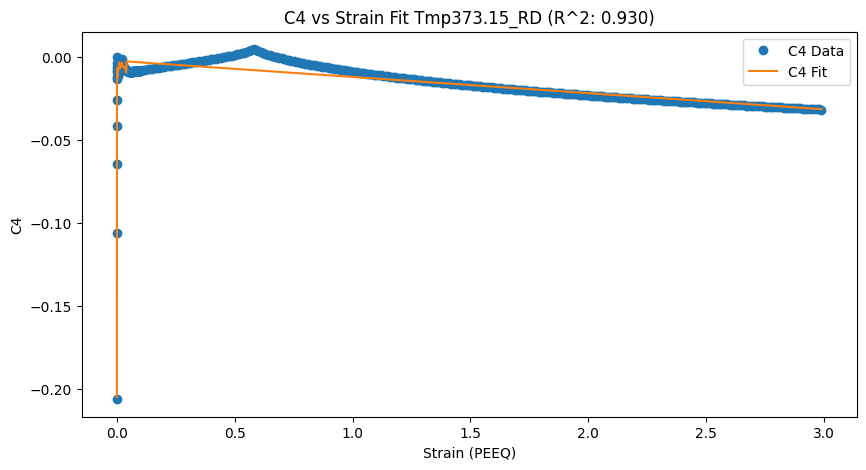

Parameters for C1: [-2.96167176e+00 -4.33948280e+03  1.82039307e+00  1.66325109e+06
 -3.64353397e+03  2.61286304e+03  3.95214278e-05 -2.61294769e+03
  3.06367635e-01 -2.52346658e+02 -7.38534424e-01  7.22955682e+01
 -6.85557021e+01 -3.43803847e+00  4.51483328e-02  1.50000000e-03
  3.80000000e-02]
Parameters for C2: [ 0.19240488 -2.90387864  0.07365938  4.04022503  0.01033125  0.06288518
  0.08538773]
Parameters for C3: [-3.02750508e+08  5.73678747e+05  4.67216835e+02 -3.94994780e-01
 -9.12719182e+04  6.76519485e+03 -1.38759876e+02  7.70357020e-01
  1.05810125e-01 -4.42888207e-01  2.71657963e-01]
Parameters for C4: [-1.97818114e-01 -5.69463288e+03  2.01400047e+03 -6.91885202e-03
  2.08657994e+02 -4.67679071e-05 -2.08660057e+02  6.28656332e-03
  5.15582918e+02 -9.20099564e+00  7.82890362e+01 -1.09521746e+01
  4.25669643e-01 -8.55157707e-03]


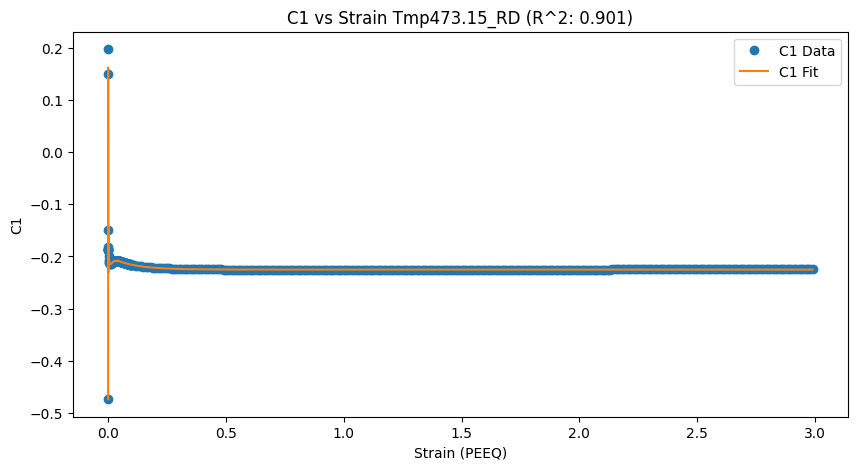

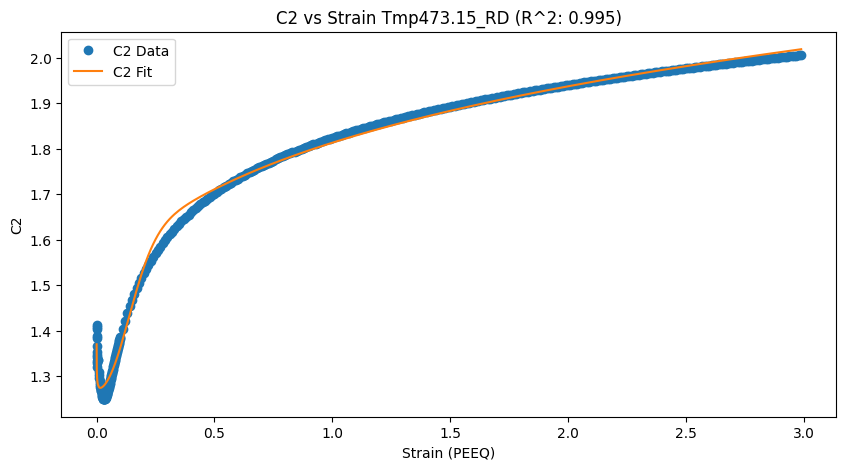

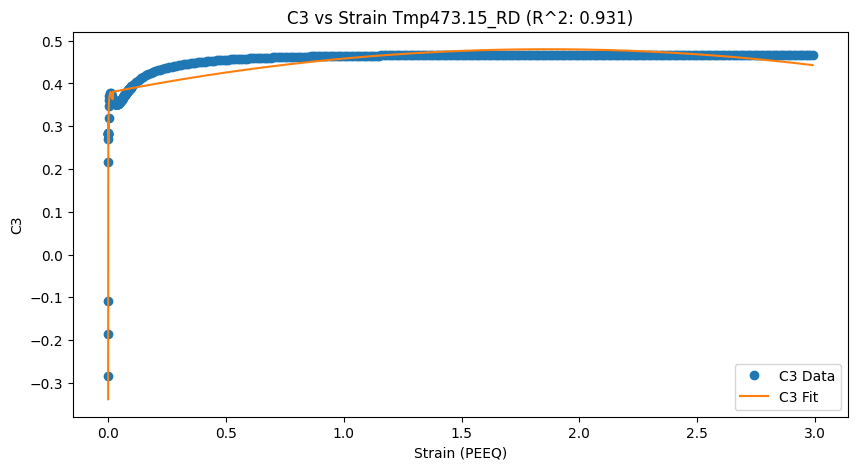

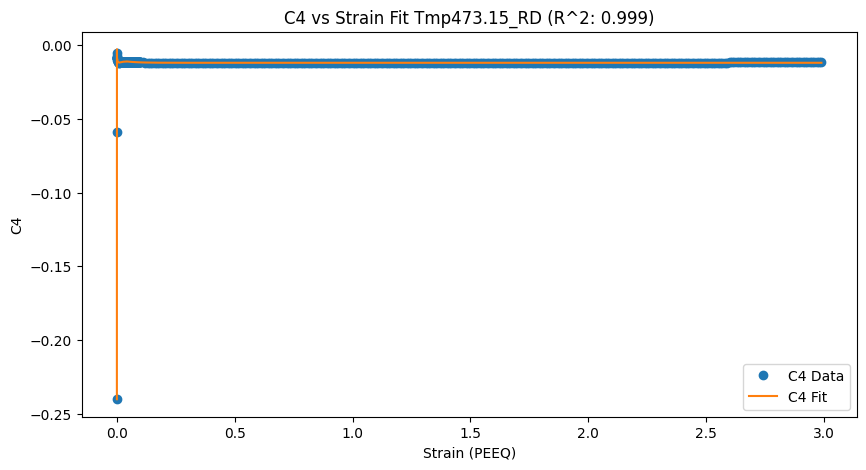

Parameters for C1: [-8.23733133e-01 -3.21133830e+04  3.50198787e-01  1.12557432e+06
 -1.61847608e+03  2.56641698e-02 -1.01414887e+01 -2.25247604e-01
  8.99168204e-02 -2.74267960e+01 -1.20860486e+00 -6.35482904e+01
  4.02031605e+02  2.83803228e+00 -1.13667594e-01  1.50000000e-03
  3.80000000e-02]
Parameters for C2: [-0.03312533  0.6580521   0.48417754  1.28314986  0.10545129 -0.23753004
  0.03811009]
Parameters for C3: [ 6.33581494e+08 -2.17011733e+06  2.13477618e+03 -3.37956145e-01
  3.92636250e+04 -1.64083847e+03  2.01501045e+01  3.03250429e-01
 -2.92418216e-02  1.09014399e-01  3.78253351e-01]
Parameters for C4: [-2.30800768e-01 -1.04967791e+04 -7.73432274e+03 -9.38066753e-03
  2.08142124e-03 -2.01710427e+01 -1.18396243e-02  1.32771406e-01
  4.33321705e-02  3.73645335e-02  4.50270478e+02 -9.10814140e-01
  6.93914333e-02 -1.23510043e-02]


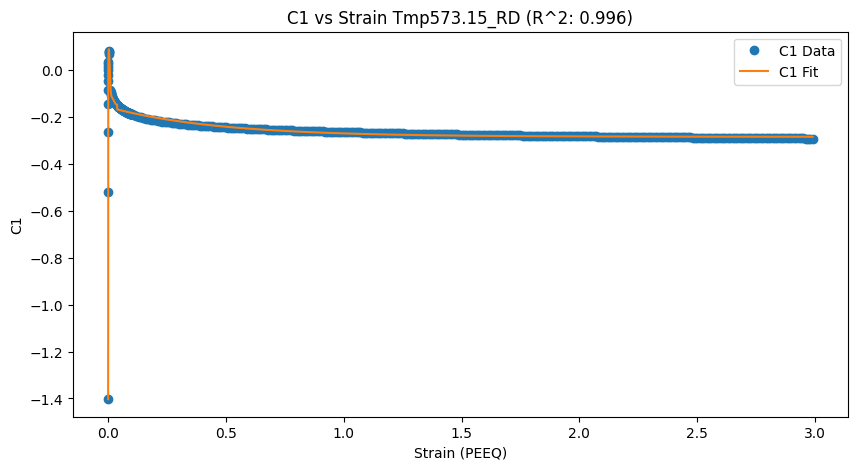

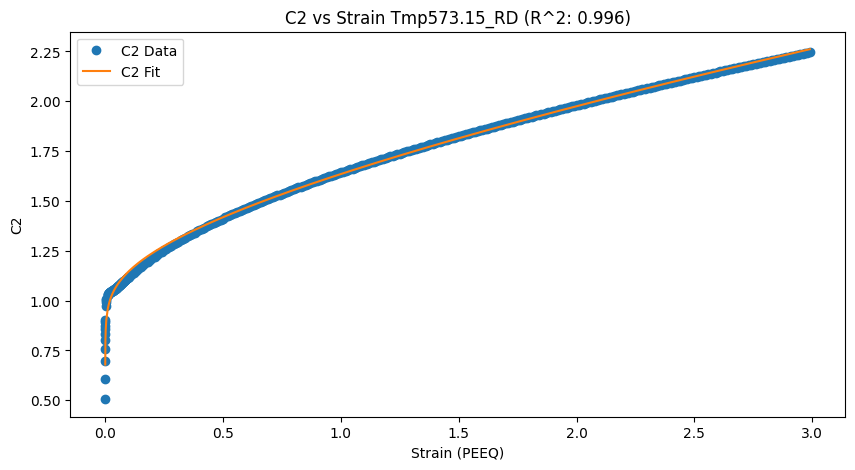

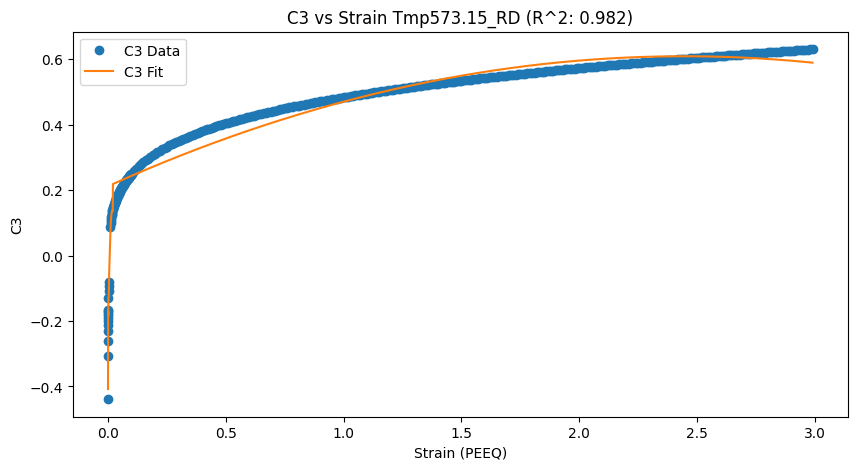

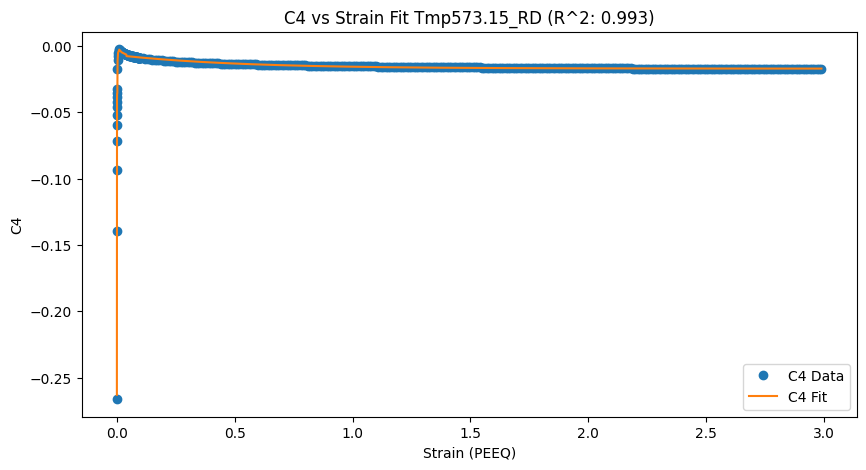

Parameters for C1: [-1.18270571e+00 -1.11478067e+04 -2.20670449e-01 -2.00775392e+05
  4.55095629e+02  1.26715338e-01 -2.16538670e+00 -2.84479337e-01
 -4.03833950e-01  3.02670194e+02 -3.26230773e+00  2.45202287e+02
  8.02370497e+01 -6.12257990e+00 -3.05099362e-02  1.50000000e-03
  3.80000000e-02]
Parameters for C2: [ 0.05829222  0.45829487  0.78513019  1.20937921  0.02730661  0.65205555
 -0.27421671]
Parameters for C3: [ 2.29294242e+08 -7.72858034e+05  7.68383915e+02 -4.07967516e-01
  2.83644980e+04 -2.25060778e+03  5.38489620e+01 -2.68575109e-01
 -6.63208094e-02  3.24497352e-01  2.11725951e-01]
Parameters for C4: [-2.27337929e-01 -6.48509604e+03  1.73123299e-03 -3.55969906e-02
  1.01985467e-02 -1.96120963e+00 -1.72013338e-02 -6.41096212e-01
 -9.28330996e+00  4.62212068e-02  2.51460314e+02 -1.67920285e+00
  4.04946527e-02 -5.53698726e-03]


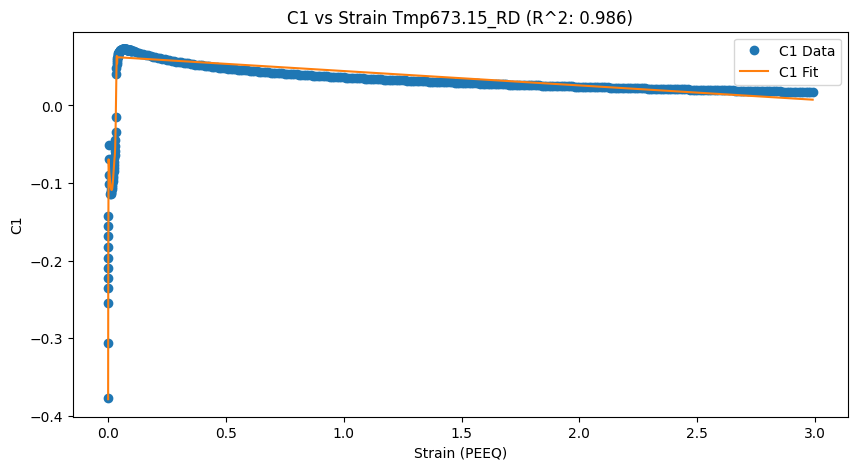

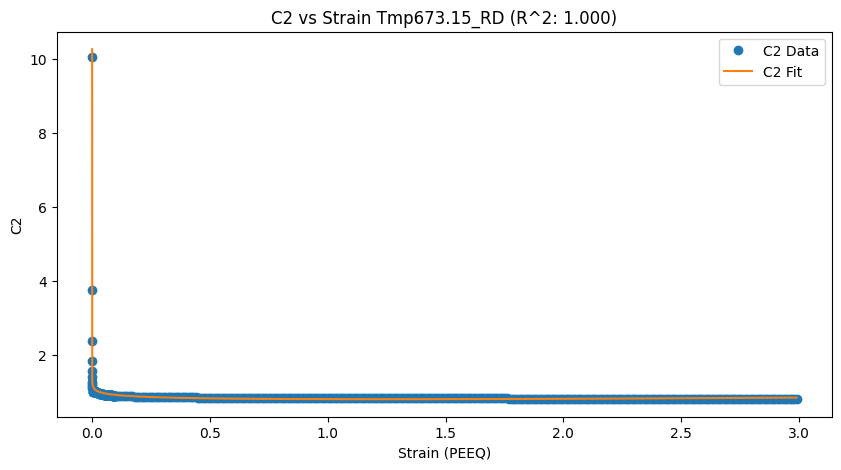

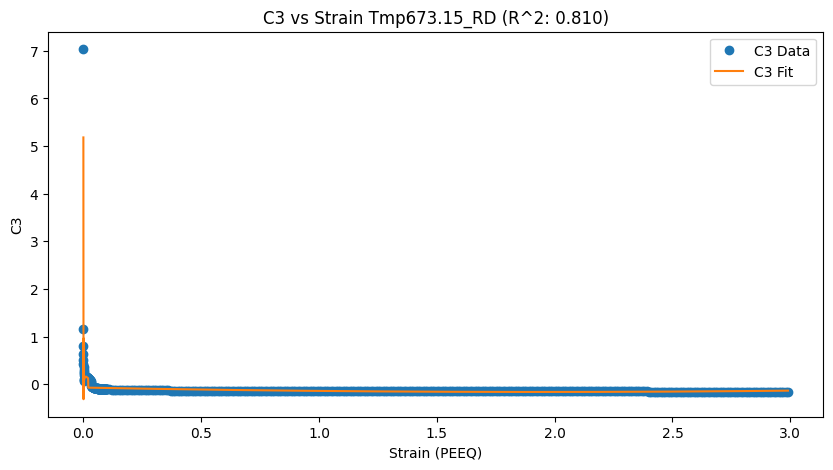

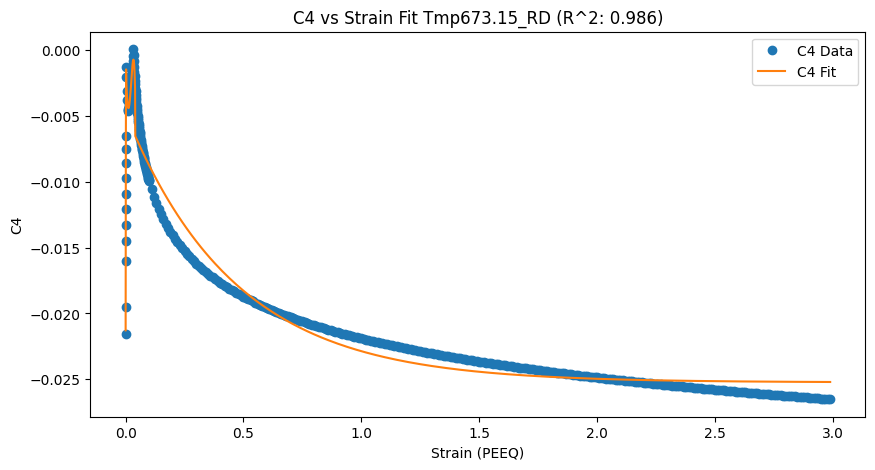

Parameters for C1: [-1.84503307e-01 -5.49578081e+03 -1.93984958e-01  1.11897649e+05
 -5.74513529e+01 -4.08383431e+02  4.53881833e-05  4.08446326e+02
  4.67803700e-05 -5.07012220e+02  1.31496170e+01 -1.89741809e+02
  2.67063549e+02 -7.54161294e+00 -5.53859250e-02  1.50000000e-03
  3.80000000e-02]
Parameters for C2: [-7.11792426e-02  1.16519315e-11 -3.00428153e+00  7.47274842e-01
 -7.06558733e-02  2.08464086e+02  6.50584305e+02]
Parameters for C3: [-7.65995345e+09  2.46131781e+07 -2.11727957e+04  5.18221146e+00
  5.67341107e+04 -2.63423781e+03  3.61650150e+01  5.05308362e-03
  2.45201641e-02 -9.50112232e-02 -7.05526616e-02]
Parameters for C4: [-2.24959602e-02 -1.06734314e+03  2.15104328e-04  1.21310786e-03
  2.04494415e-02 -2.15293060e+00 -2.52414534e-02  1.64630631e-02
 -4.05519085e-01 -6.43874618e+00 -6.85226495e+01  3.48112846e+01
 -4.11089427e-01  1.51081460e-03]


In [59]:
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

# Validate stress

In [26]:


def validate_original_function(temperature_file, strain_rates, strain_rate_columns):
    """Validates the original function using the fitted parameters and calculates R-value."""
    # Load the original data and the fitted parameters
    data = pd.read_csv(f"../{temperature_file}.csv")
    params_df = pd.read_csv(f"Fitted_Parameters_{temperature_file}.csv")
    
    r_values_list = []  # List to store R-values for each row

    # Create a PDF file to save the plots
    pdf_filename = f"Validation_Plots_{temperature_file}.pdf"
    with PdfPages(pdf_filename) as pdf:
        for i in range(len(data)):
            # Extract the parameters and stress data for comparison
            strain, C1, C2, C3, C4 = params_df.iloc[i][['strain','C1', 'C2', 'C3', 'C4']]
            stress_values = data.iloc[i][strain_rate_columns]

            # Compute stress from the original function
            fitted_stress = strain_rate_dependent_stress(np.array(strain_rates), C1, C2, C3, C4)

            # Calculate the R-value (correlation coefficient)
            residuals = stress_values - fitted_stress
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress_values - np.mean(fitted_stress))**2)
            r_value = 1 - (ss_res / ss_tot)
            r_values_list.append({'Row': strain, 'R-value': r_value})

            # Plot only a limited number of rows for visual validation
            plt.figure(figsize=(10, 5))
            plt.plot(strain_rates, stress_values, 'o', label='Original Data')
            plt.plot(strain_rates, fitted_stress, '-', label='Fitted Model')
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f'Validation for Row {i} {temperature_file} (R-value = {r_value:.3f})')
            plt.legend()
            plt.grid()
            pdf.savefig()  # Save the current figure to the PDF
            plt.close()  # Close the figure to avoid displaying it multiple times

    # Save R-values to CSV
    r_values_df = pd.DataFrame(r_values_list)
    r_values_df.to_csv(f"R_values_{temperature_file}.csv", index=False)
    print(f"Plots saved to {pdf_filename} and R-values saved to CSV.")

# Example usage
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
validate_original_function(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    validate_original_function(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)


Plots saved to Validation_Plots_Tmp298.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp373.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp473.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp573.15_RD.pdf and R-values saved to CSV.
Plots saved to Validation_Plots_Tmp673.15_RD.pdf and R-values saved to CSV.


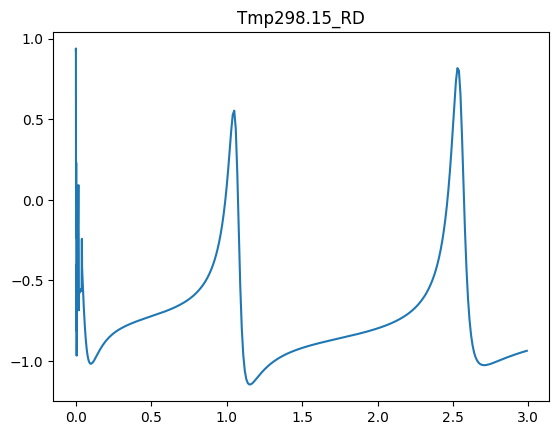


Temperature File: Parameters_Tmp298.15_RD.csv
Number of rows with R_squared < 0.8: 390
Percentage of rows with R_squared < 0.8: 98.73%


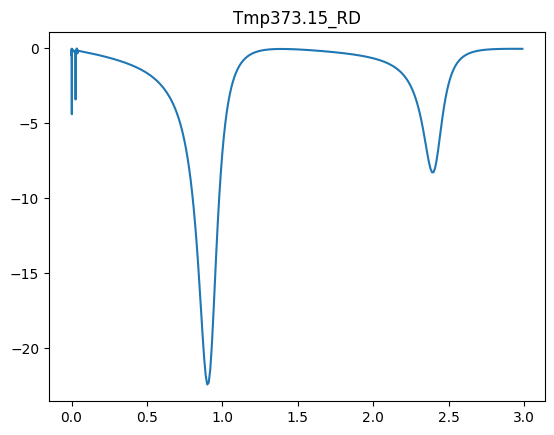


Temperature File: Parameters_Tmp373.15_RD.csv
Number of rows with R_squared < 0.8: 395
Percentage of rows with R_squared < 0.8: 100.00%


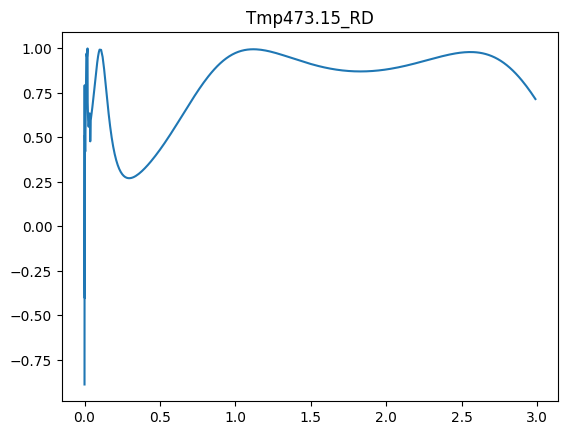


Temperature File: Parameters_Tmp473.15_RD.csv
Number of rows with R_squared < 0.8: 135
Percentage of rows with R_squared < 0.8: 34.18%


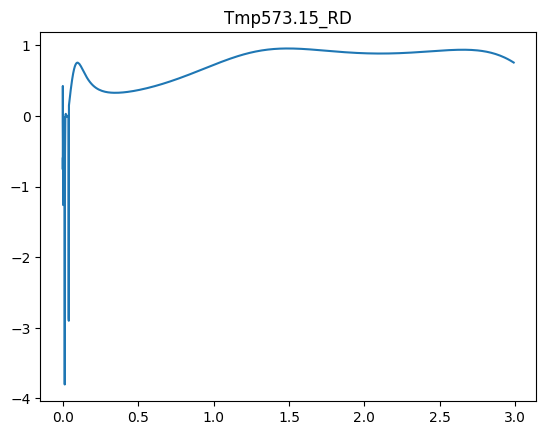


Temperature File: Parameters_Tmp573.15_RD.csv
Number of rows with R_squared < 0.8: 209
Percentage of rows with R_squared < 0.8: 52.91%


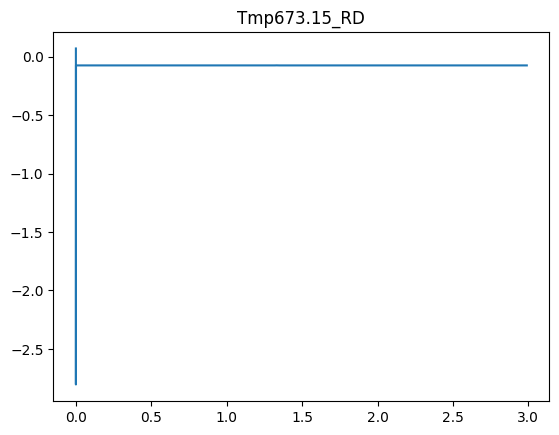


Temperature File: Parameters_Tmp673.15_RD.csv
Number of rows with R_squared < 0.8: 395
Percentage of rows with R_squared < 0.8: 100.00%


In [27]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.80
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"R_values_{temp_file}.csv")
        
        plt.plot(df['Row'],df['R-value'])
        plt.title(f"{temp_file}")
        plt.show()
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_low_r_squared = df[df['R-value'] < threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_low_r_squared > 0:
            print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
            print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
        else:
            print(f"All R_squared values are >= {threshold}.")

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)
